In [1]:
from google.colab import drive

!pip install pymupdf
!pip install transformers pymupdf --quiet

import os
import re
import fitz  # PyMuPDF
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms, models
from transformers import AutoTokenizer, AutoModel
AutoModel.from_pretrained("bert-base-uncased", force_download=True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 100.0 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

Funções

In [2]:
def extract_text_from_pdf(pdf_path):
    try:
        doc = fitz.open(pdf_path)
        full_text = ""
        for page in doc:
            full_text += page.get_text() + " "
        return full_text.strip()
    except Exception as e:
        print(f"[ERRO] Falha ao ler o PDF: {pdf_path}")
        print(e)
        return ""

def clean_text(text):
    text = text.lower()
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"[^a-z0-9,.;:()\- ]", "", text)
    return text.strip()

def extract_categoria_birads(text):
    match = re.search(r'categoria\s*(\d)\s*\(bi\-rads\®?\)', text, re.IGNORECASE)
    if match:
        cat = match.group(1)
        return f"Categoria {cat} (BI-RADS®)", int(cat)
    else:
        return "Categoria 0 (Indefinida)", 0

def png_to_tensor_3ch(png_path):
    pil_img = Image.open(png_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
    ])
    return transform(pil_img)

def extrair_amostra(pdf_path, png_path):
    print(f"📄 Lendo laudo de: {pdf_path}")
    texto = extract_text_from_pdf(pdf_path)

    if texto.strip() == "":
        print("⚠️ Nenhum texto encontrado no laudo!")
    else:
        print("✅ Texto extraído com sucesso!")

    texto_limpo = clean_text(texto)
    print(f"\n📝 Texto limpo do laudo:\n{texto_limpo[:500]}{'...' if len(texto_limpo) > 500 else ''}\n")

    categoria_str, categoria_num = extract_categoria_birads(texto_limpo)
    print(f"🏷️ Categoria detectada: {categoria_str} (número {categoria_num})")

    imagem_tensor = png_to_tensor_3ch(png_path)
    print(f"🖼️ Imagem carregada com shape: {imagem_tensor.shape}\n")

    return imagem_tensor, categoria_str, categoria_num


Dataset multimodal

In [3]:
class MammographyMultiImageDataset(Dataset):
    def __init__(self, image_dir, pdf_dir, tokenizer, max_length=128):
        self.image_dir = image_dir
        self.pdf_dir = pdf_dir
        self.tokenizer = tokenizer
        self.max_length = max_length

        self.pdf_texts = {}
        self.pdf_labels = {}
        self.samples = []

        pdf_files = [f for f in os.listdir(pdf_dir) if f.endswith(".pdf")]
        for pdf_file in pdf_files:
            prefix = pdf_file[:-4]
            pdf_path = os.path.join(pdf_dir, pdf_file)
            text = extract_text_from_pdf(pdf_path)
            clean = clean_text(text)
            _, label = extract_categoria_birads(clean)
            self.pdf_texts[prefix] = clean
            self.pdf_labels[prefix] = label

            imgs = [f for f in os.listdir(image_dir) if f.startswith(prefix+"_") and f.endswith(".png")]
            for img in imgs:
                img_path = os.path.join(image_dir, img)
                self.samples.append((img_path, clean, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, text, label = self.samples[idx]
        img_tensor = png_to_tensor_3ch(img_path)
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        return {
            "image": img_tensor,
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

Modelo multimodal simples (CNN + BERT)

In [4]:
class MultiModalClassifier(nn.Module):
    def __init__(self, text_model_name="bert-base-uncased", image_model_name="resnet18", num_classes_birads=6, num_classes_skin=2):
        super().__init__()

        # Texto (BERT)
        self.text_model = AutoModel.from_pretrained(text_model_name)
        text_hidden_size = self.text_model.config.hidden_size

        # Imagem (ResNet)
        self.image_model = models.resnet18(pretrained=True)
        num_ftrs = self.image_model.fc.in_features
        self.image_model.fc = nn.Identity()  # Remove a última camada para pegar as features

        image_feat_size = num_ftrs

        combined_size = text_hidden_size + image_feat_size

        # Classificador para BI-RADS (6 classes)
        self.birads_classifier = nn.Sequential(
            nn.Linear(combined_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes_birads)
        )

        # Classificador para condição da pele (2 classes)
        self.skin_classifier = nn.Sequential(
            nn.Linear(combined_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes_skin)
        )

    def forward(self, input_ids, attention_mask, images):
        # Texto (BERT)
        text_outputs = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        text_embeds = text_outputs.pooler_output  # [batch, hidden_size]

        # Imagem (ResNet)
        image_embeds = self.image_model(images)  # [batch, image_feat_size]

        # Combina texto + imagem
        combined = torch.cat((text_embeds, image_embeds), dim=1)

        # Duas saídas
        birads_logits = self.birads_classifier(combined)  # [batch, 6]
        skin_logits = self.skin_classifier(combined)      # [batch, 2]

        return birads_logits, skin_logits

Preparar tokenizer e dataset

In [5]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Diretórios atualizados
train_image_dir = "/content/drive/MyDrive/imgCeonc/train/images"
train_pdf_dir = "/content/drive/MyDrive/imgCeonc/train/reports"

val_image_dir = "/content/drive/MyDrive/imgCeonc/valid/images"
val_pdf_dir = "/content/drive/MyDrive/imgCeonc/valid/reports"

print("Iniciando criação dos datasets...")
train_dataset = MammographyMultiImageDataset(train_image_dir, train_pdf_dir, tokenizer)
print(f"Dataset de treino criado com {len(train_dataset)} amostras")

val_dataset = MammographyMultiImageDataset(val_image_dir, val_pdf_dir, tokenizer)
print(f"Dataset de validação criado com {len(val_dataset)} amostras")

print("Criando dataloaders...")
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)
print("Dataloaders criados com sucesso!")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Iniciando criação dos datasets...
Dataset de treino criado com 6792 amostras
Dataset de validação criado com 5614 amostras
Criando dataloaders...
Dataloaders criados com sucesso!


Treinamento

In [6]:
import traceback

try:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MultiModalClassifier().to(device)
except Exception as e:
    print("Erro ao mover o modelo para o dispositivo:")
    traceback.print_exc()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        images = batch['image'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        output = model(input_ids, attention_mask, images)

        # Corrigir aqui para extrair tensor
        if isinstance(output, tuple):
            logits = output[0]
        else:
            logits = output

        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = logits.argmax(dim=1)
        total_correct += (preds == labels).sum().item()
        total_samples += labels.size(0)

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples

    return avg_loss, accuracy


def eval_epoch(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    total_correct = 0

    with torch.no_grad():
        for batch in dataloader:
            images = batch["image"].to(device)
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)  # <- veja se sua chave é 'label' ou 'labels'

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, images=images)
            logits = outputs[0] if isinstance(outputs, tuple) else outputs

            loss = criterion(logits, labels)

            total_loss += loss.item() * labels.size(0)
            preds = logits.argmax(dim=1)
            total_correct += (preds == labels).sum().item()

    return total_loss / len(dataloader.dataset), total_correct / len(dataloader.dataset)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 167MB/s]


Loop de treino

In [7]:
num_epochs = 5

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = eval_epoch(model, val_loader, criterion)

    print("---------------------------------------------------------")
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f" Train loss: {train_loss:.4f}, accuracy: {train_acc:.4f}")
    print(f" Val   loss: {val_loss:.4f}, accuracy: {val_acc:.4f}")

---------------------------------------------------------
Epoch 1/5
 Train loss: 0.6406, accuracy: 0.7678
 Val   loss: 0.7561, accuracy: 0.7072
---------------------------------------------------------
Epoch 2/5
 Train loss: 0.7349, accuracy: 0.7141
 Val   loss: 0.7127, accuracy: 0.7289
---------------------------------------------------------
Epoch 3/5
 Train loss: 0.6836, accuracy: 0.7469
 Val   loss: 0.6990, accuracy: 0.7431
---------------------------------------------------------
Epoch 4/5
 Train loss: 0.6227, accuracy: 0.7680
 Val   loss: 0.7634, accuracy: 0.6990
---------------------------------------------------------
Epoch 5/5
 Train loss: 0.5476, accuracy: 0.7990
 Val   loss: 0.7622, accuracy: 0.7104


In [8]:
# 🔒 Salvando o modelo treinado
torch.save(model.state_dict(), "/content/drive/MyDrive/imgCeonc/multimodal_birads_model.pth")
print("✅ Modelo salvo com sucesso em: /content/drive/MyDrive/imgCeonc/multimodal_birads_model.pth")

✅ Modelo salvo com sucesso em: /content/drive/MyDrive/imgCeonc/multimodal_birads_model.pth


In [9]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


In [12]:
def get_predictions(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in dataloader:
            images = batch["image"].to(device)
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, images=images)

            # Corrigir aqui: outputs é uma tupla, extrair os logits
            logits = outputs[0] if isinstance(outputs, tuple) else outputs
            preds = logits.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds



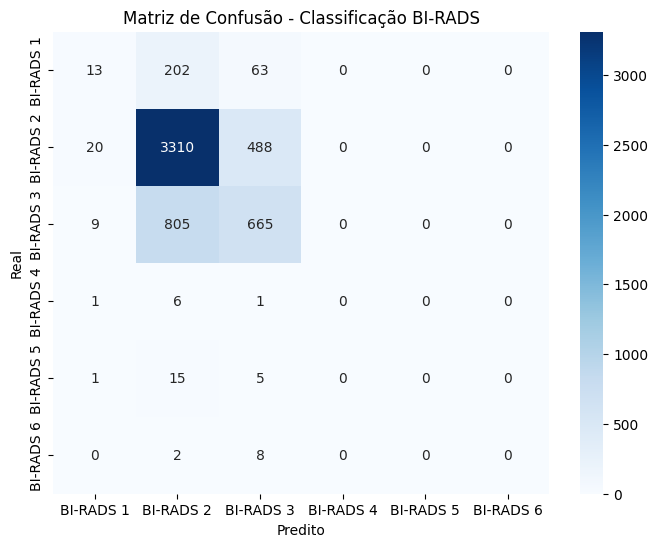

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Obter os rótulos verdadeiros e previstos
true_labels, predicted_labels = get_predictions(model, val_loader)

# Matriz de confusão
cm = confusion_matrix(true_labels, predicted_labels)

# Rótulos das classes BI-RADS (1 a 6)
labels = ["BI-RADS 1", "BI-RADS 2", "BI-RADS 3", "BI-RADS 4", "BI-RADS 5", "BI-RADS 6"]

# Exibir a matriz de confusão
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão - Classificação BI-RADS")
plt.show()



In [15]:
target_names = ["Classe 1", "Classe 2", "Classe 3", "Classe 4", "Classe 5", "Classe 6"]
print(classification_report(true_labels, predicted_labels, target_names=target_names))

              precision    recall  f1-score   support

    Classe 1       0.30      0.05      0.08       278
    Classe 2       0.76      0.87      0.81      3818
    Classe 3       0.54      0.45      0.49      1479
    Classe 4       0.00      0.00      0.00         8
    Classe 5       0.00      0.00      0.00        21
    Classe 6       0.00      0.00      0.00        10

    accuracy                           0.71      5614
   macro avg       0.27      0.23      0.23      5614
weighted avg       0.68      0.71      0.69      5614



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
